In [1]:
%matplotlib inline
from math import sqrt, log
import matplotlib.pyplot as plt
from matplotlib.colors import rgb_to_hsv,hsv_to_rgb
import numpy as np
from numpy.linalg import norm
import pandas as pd
import pdb
from sklearn.linear_model import Lasso
import sklearn.linear_model as lm
from sklearn.preprocessing import scale, StandardScaler
import seaborn as sns
from time import sleep

# Génération aléatoire

In [2]:
def gen_linear(a, b, eps, nbex):
    x = np.random.uniform(-5, 5, (nbex, len(a)))
    noise = np.random.normal(scale=eps, size=(nbex, 1))
    a = np.array(a)
    a= a.reshape(len(a),1)
    y = np.add(np.dot(x,a), noise)
    y = np.add(y, b)
    return x,y

def gen_linear_no_noise(a, b, nbex):
    x = np.random.uniform(-5, 5, (nbex, len(a)))
    a = np.array(a)
    a= a.reshape(len(a),1)
    y = np.dot(x,a)
    y = np.add(y, b)
    return x,y

In [3]:
# Parameters values
a = [1, 1, 1]
#a = [1]
b = 5
eps_0 = sqrt(1)
n = 1000


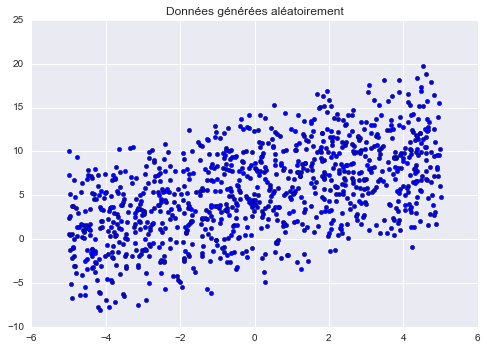

In [4]:
x, y = gen_linear(a, b, eps_0, n) 
plt.figure()
plt.scatter(x[:,0], y)
plt.title("Données générées aléatoirement")

# Données réelles : Boston Housing


In [5]:
def read_file (fn ):
    with open (fn) as f:
        names =f. readline ()
        X=np. array ([[ float (x) for x in l. strip (). split (" ")] 
                      for l in f. readlines ()])
    return X[: ,: -1] ,X[: , -1]. reshape ( -1)

In [6]:
df = read_file("housing.csv")

In [7]:
x_df, y_df = df[0], df[1]

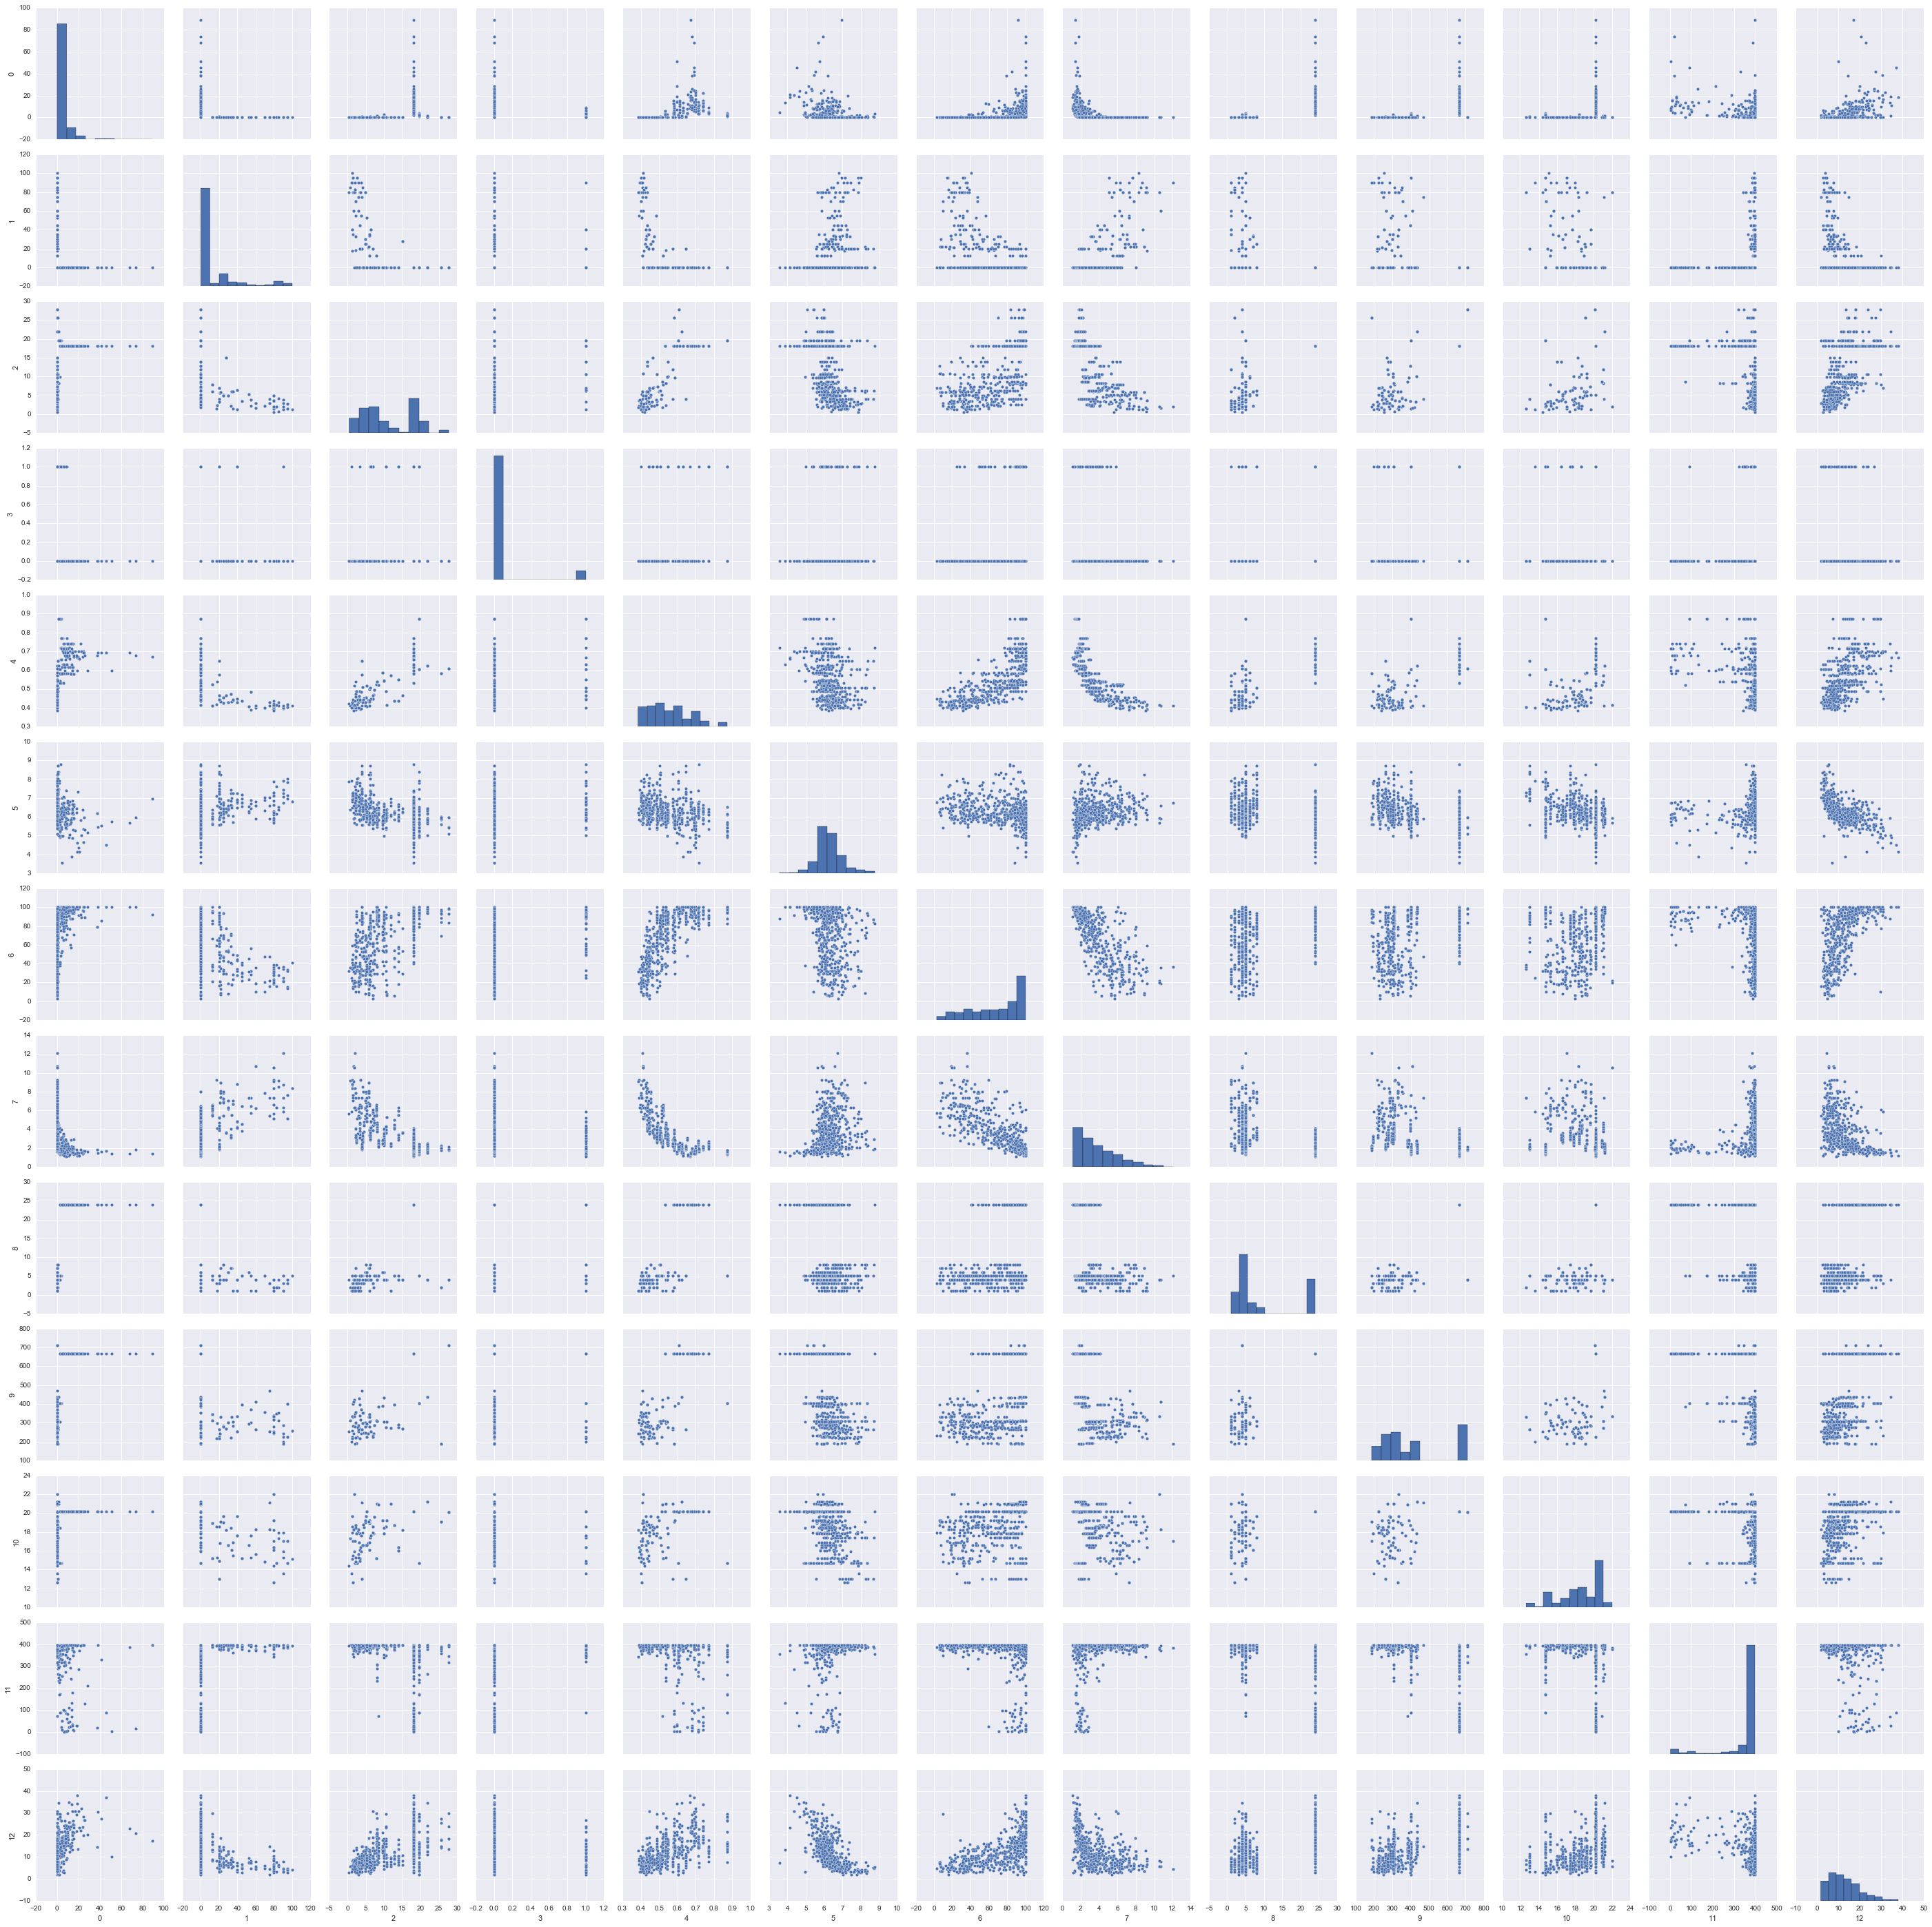

In [8]:
# Pour visualiser le diagramme de corrélations de nos données, on s'est permis d'utiliser la bibliothèqe Seaborn
# qui le fait très bien
m_df = pd.DataFrame(x_df)
sns.pairplot(m_df, size=3)

On observe que certaines données sont extrêmement corrélées, et donc que certaines variables explicatives apportent vraisemblablement la même information

# Régression linéaire

Préambule:

On écrit $x^*$ le vecteur $(1, x)$ où x est un vecteur de taille d. $x^*$ est donc un vecteur de $R^{d+1}$.

On a donc aussitôt:
$$f_w(x) = w.x^*$$

De même, si l'on note $X$ la matrice $(x^*_1, ..., x^*_N)$ où $x^*_i$ est le vecteur i généralisé on obtient:
$$f_w(X) = X \times (w_0, w_1, ..., w_d) = X \times w$$

Calcul de l'erreur des moindres carrés:

Pour tout $x,y \in X,Y$ point de la base d'apprentissage:
$$l(y, f_w(x)) = (y - f_w(x))^2$$

Donc pour l'ensemble de la base d'apprentissage:
$$R = \frac{1}{N} \sum_1^N (y_i -f_w(x_i))^2$$
$$R = \frac{1}{N} (Y-X \times w)^2 $$

On peut remarquer que ce risque est fortement convexe. L'optimum $w$ est donc obtenu là où le gradient s'annule. Après calcul, on trouve l'estimateur des moindres carrés: 

$$w = (X^TX)^{-1}X^TY$$

In [8]:
def resize(x):
    return np.hstack((np.ones(len(x)).reshape(-1, 1), x))

def predict(w, X):
    Xp = resize(X)
    return np.dot(Xp, w)  # A tester

def mse(yhat, y):
    """Renvoit l'erreur entre yhat et y"""
    assert(len(yhat) == len(y))
    n = len(yhat)    
    return ((1/n)*(np.dot(np.transpose(y-yhat), (y-yhat))))


def regress(X, Y):
    """Renvoit l'estimateur w_hat estimateur des moindres carrés
    en régression linéaire sur la base d'apprentissage (X, Y)"""
    Xp = resize(X)
    mat_1 = np.linalg.pinv(np.dot(np.transpose(Xp), Xp))
    mat_2 = np.dot(np.transpose(Xp), Y)
    return np.dot(mat_1, mat_2)

## Utilisation de la régression linéaire sur des données simulées

In [9]:
x_sim = x
y_sim = y
w_estim = regress(x_sim, y_sim)
print(w_estim)
# On s'apercoit que l'estimateur des moindres carrés est plutôt bon et est proche du résultat attendu 
print(mse(predict(w_estim, x_sim), y_sim))

[[ 5.0767057 ]
 [ 0.9869075 ]
 [ 0.98594388]
 [ 1.01957067]]
[[ 1.02621639]]


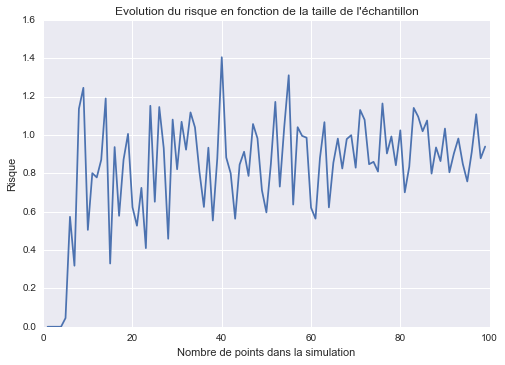

In [10]:
# Evolution du risque en fonction du nombre de points pour l'estimateur des moindres carrés
nbexs = [i for i in range(1, 100)]
risk = []
for n in nbexs:
    x_sim, y_sim = gen_linear(a, b, 1, n)
    w_estim = regress(x_sim, y_sim)
    risk.append(mse(predict(w_estim, x_sim), y_sim)[0][0])
plt.plot(nbexs, risk)
plt.title("Evolution du risque en fonction de la taille de l'échantillon")
plt.xlabel("Nombre de points dans la simulation")
plt.ylabel("Risque")

On peut remarquer que le risque converge vers $\epsilon$, la variance du bruit gaussien. On remarque en effet que $MSE$ correspond à l'estimateur de la variance de la variable aléatoire gaussienne.

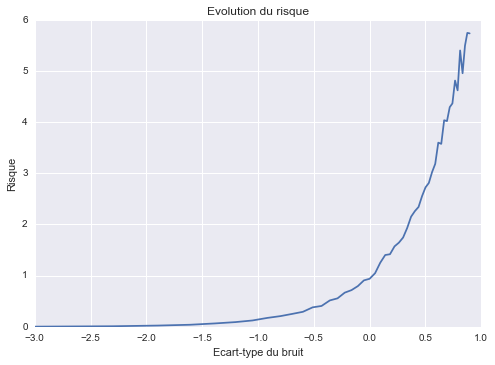

In [11]:
# Evolution du risque en fonction de la variance pour l'estimateur des moindres carrés
n = 1000
stds = [0.05*i for i in range(1, 50)]
risk = []
for std in stds:
    x_sim, y_sim = gen_linear(a, b, std, n)
    w_estim = regress(x_sim, y_sim)
    risk.append(mse(predict(w_estim, x_sim), y_sim)[0][0])
log_stds = [log(std) for std in stds]
plt.plot(log_stds, risk)
plt.title("Evolution du risque")
plt.xlabel("Ecart-type du bruit")
plt.ylabel("Risque")

On remarque que quand l'écart-type est faible (autrement dit moins il y a de brut), le risque a tendance à tendre vers 0.
C'est logique.

In [12]:
w_true = np.array([5,1,1,1]).reshape(-1, 1)

In [13]:
# Ajout de dimensions aléatoires
x_sim, y_sim = gen_linear(a, b, 1, 500)
x_sim_alea = np.hstack((x_sim, np.random.rand(len(x_sim), 2)))  # Ajout de 2 dimensions aléatoires

w = regress(x_sim, y_sim)
w_alea = regress(x_sim_alea, y_sim)

print("Estimateur normal:")
print(w)
print("Ecart quadratique sur les poids")
print(np.dot(np.transpose(w-w_true), w-w_true))
print("\n \n Estimateur avec 2 dimensions d'explication aléatoires supplémentaires:")
print(w_alea)
print("Ecart quadratique sur les poids")
print(np.dot(np.transpose(w_alea[:4]-w_true), w_alea[:4]-w_true))

Estimateur normal:
[[ 4.94142699]
 [ 0.97357324]
 [ 0.99282159]
 [ 1.01751028]]
Ecart quadratique sur les poids
[[ 0.00448731]]

 
 Estimateur avec 2 dimensions d'explication aléatoires supplémentaires:
[[ 4.86577682]
 [ 0.97321488]
 [ 0.99327704]
 [ 1.01769476]
 [ 0.01064372]
 [ 0.13225102]]
Ecart quadratique sur les poids
[[ 0.01909161]]


AJOUTER PROCESSUS
Pê tracer poids relatif des dimentions aléatoires et intépreter.

## Application à la base de données réelle

Ainsi, on remarque que l'écart quadratique sur les poids en ajoutant des dimensions a tendance a être plus grand que sans dimensions aléatoires.

In [14]:
x_train = x_df
y_train = y_df
w = regress(x_train, y_train)
print(w)

[  3.64594884e+01  -1.08011358e-01   4.64204584e-02   2.05586264e-02
   2.68673382e+00  -1.77666112e+01   3.80986521e+00   6.92224641e-04
  -1.47556685e+00   3.06049479e-01  -1.23345939e-02  -9.52747232e-01
   9.31168327e-03  -5.24758378e-01]


Interprétation des poids :
On peut grossièrement supposer que si les variables explicatives ont même ordre de grandeur, l'amplitude des coefficients reflète le poids des variables explicatives sur la variable à expliquer, et donc le degré d'information qu'elle apporte.

In [15]:
# On multiplie par 10 un des coefficients
index = 9
print(x_train[1:10, index])
x_train[:, index] *= 10
print(x_train[1:10, index])
w_bis = regress(x_train, y_train)
print(w_bis)

[ 242.  242.  222.  222.  222.  311.  311.  311.  311.]
[ 2420.  2420.  2220.  2220.  2220.  3110.  3110.  3110.  3110.]
[  3.64594883e+01  -1.08011358e-01   4.64204584e-02   2.05586263e-02
   2.68673382e+00  -1.77666112e+01   3.80986521e+00   6.92224628e-04
  -1.47556684e+00   3.06049479e-01  -1.23345939e-03  -9.52747231e-01
   9.31168328e-03  -5.24758378e-01]


In [16]:
print("Poids de l'indice avant multiplication", w[index])
print("Poids de l'indice après multiplication", w_bis[index])
print("Rapport", w_bis[index]/w[index])

Poids de l'indice avant multiplication 0.306049478999
Poids de l'indice après multiplication 0.3060494788
Rapport 0.99999999935


En multipliant les indices par 10, on s'aperçoit que cela ne modifie pas la valeur des poids associés. Il n'est donc pas évident de pouvoir considérer tels quels les poids de $w$

Afin de comparere des grandeurs comparables, il peut être pertinent de normaliser les valeurs des paramètres.

In [17]:
# Utilisation de la fonction sklearn de la bibliothèque sklearn.preprocessing
X = scale(x_df)
y = y_df

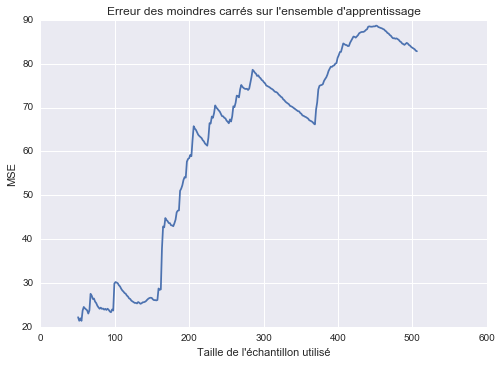

In [18]:
# Tracé de la MSE en fonction du nombre de données utilisées
np.random.shuffle(X)
sizes = np.linspace(0.1*len(X), len(X), num=300)
MSE_sample = []
for size in sizes:
    size = int(size)
    w_sample = regress(X[:size], y[:size])
    MSE_sample.append(mse(y[:size], predict(w_sample, X[:size])))

plt.plot(sizes, MSE_sample)
plt.title("Erreur des moindres carrés sur l'ensemble d'apprentissage")
plt.ylabel("MSE")
plt.xlabel("Taille de l'échantillon utilisé")

Il est clair que notre protocole de validation n'est pas adapté. En effet, plus on considère de points, plus la $MSE$ empirique calculée sur l'ensemble d'entraînement augmente!
En l'état, la $MSE$ n'est donc pas une bonne statistique pour jauger de la performance de notre régression

En fait, utiliser notre ensemble d'apprentissage pour estimer l'erreur des moindres carrés n'est pas judicieux car nous avons justement utilisé cet ensemble pour fitter notre modèle. 
Pour pallier à cette faible, nous pouvons recourrir à un protocole de validation simple, en scindant notre ensemble de départ en un **ensemble d'entraînemenet** et un **ensemble de validation**

In [19]:
np.random.shuffle(X)
def mse_simple_valid(fraction):
    indexes = int(len(x_df)*fraction)
    x_train0, x_valid0 = X[:indexes], X[indexes:]
    y_train0, y_valid0 = y[:indexes], y[indexes:]
    w = regress(x_train0, y_train0)
    y_hat = predict(w, x_valid0)
    return mse(y_hat, y_valid0)

print(mse_simple_valid(0.8))

102.50509775


CI DESSOUS REMPLACE PAR UN LINSPACE

PENSER AUSSI A METTRE SUR UN MEME GRAPHE ERREUR SUR BASE DE TEST/ENTRAINEMENT ET OBSERVER SENS DE VARIATION OPPOSES

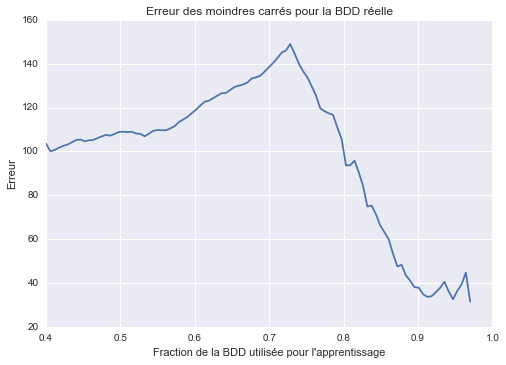

In [20]:
# Generalisation : Tracé de l'erreur des moindres carrés en fonction de la taille
# de l'ensemble d'entraînement
n_points = 25
fracs = np.linspace(0.4, 0.97, num=100)
mses = []
for frac in fracs:
    mses.append(mse_simple_valid(frac))
plt.plot(fracs, mses)
plt.title("Erreur des moindres carrés pour la BDD réelle")
plt.xlabel("Fraction de la BDD utilisée pour l'apprentissage")
plt.ylabel("Erreur")

Cette fois-ci, la tendance de la courbe est cohérente avec nos attentes concernant la statistique $MSE$

In [21]:
# Création des ensembles d'entraînement/validation pour les données réelles
frac = 0.9
indexs = int(len(x_df)*frac)

# Hypothesis : datasets are large enough to suppose that training and validation sets have same mean/std
x_train, x_valid = X[:indexs], X[indexs:]
y_train, y_valid = y[:indexs], y[indexs:]


In [22]:
# ... Et sur données simulées
x_sim, y_sim = gen_linear(a, b, eps_0, n)

x_sim = scale(x_sim)  # Normalisation de x_sim

indexs = int(len(x_sim)*frac)
x_sim_train, x_sim_valid = x_sim[:indexs], x_sim[indexs:]
y_sim_train, y_sim_valid = y_sim[:indexs], y_sim[indexs:]

# Ridge Regression

Il peut arriver que certaines variables explicatives soient comme pour notre base de données fortement corrélées, ou pire colinéaires.
Comme cette redondance ajoute inutilement de la complexité à notre prédiction, on veut pouvoir pénaliser ce type de complexité.
On ajoute ainsi une **pénalité** sur la norme 2 au carré de $w$ dans la fonction objectif 

La nouvelle fonction de risque s'écrit:
$$R_r = \frac{1}{N} (Y-X \times w)^2 + \lambda ||w||^2$$
où $\lambda$ est un paramètre fixé

On cherche $\hat{w}=argmin_w R_r(w)$

Encore une fois, par argument de forte convexité, l'estimateur $\hat{w}$ est obtenu au zéro du gradient de la fonction objectif. 
$$\nabla(R_r(w))=0 \Leftrightarrow -X^TY + (X^TX+2\lambda I) w = 0$$

Autrement dit, $\hat{w} = (X^TX+\lambda I)^{-1}X^TY$

In [23]:
def ridge_regress(X0, Y0, lmd):
    X0 = resize(X0)
    lig, col = np.shape(X0)
    mat_1 = np.linalg.pinv(np.dot(np.transpose(X0), X0) + lmd*np.eye(col, col))
    mat_2 = np.dot(np.transpose(X0), Y0)
    return np.dot(mat_1, mat_2)

## Propriétés de la Ridge Regression sur des données simulées ...

In [24]:
lmds = np.logspace(-5, 3, num=100)
err_mse = []
err_w = []
for lmd in lmds:
    w_sim = ridge_regress(x_sim_train, y_sim_train, lmd)
    err_mse.append(mse(y_sim_valid, predict(w_sim, x_sim_valid))[0][0])
    err_w.append(norm(w_sim-w_true))

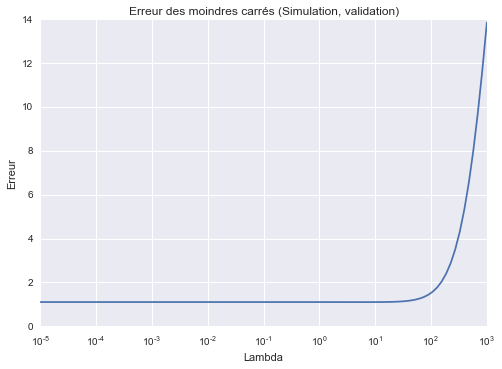

In [25]:
plt.plot(lmds, err_mse)
plt.xscale('log')
plt.title('Erreur des moindres carrés (Simulation, validation)')
plt.xlabel("Lambda")
plt.ylabel("Erreur")

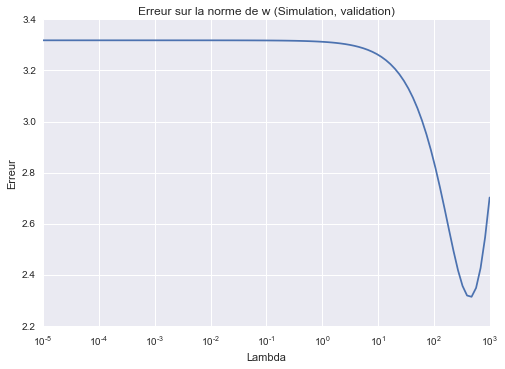

In [26]:
plt.plot(lmds, err_w)
plt.xscale('log')
plt.title('Erreur sur la norme de w (Simulation, validation)')
plt.xlabel("Lambda")
plt.ylabel("Erreur")

## ... Et sur notre base de données réelles

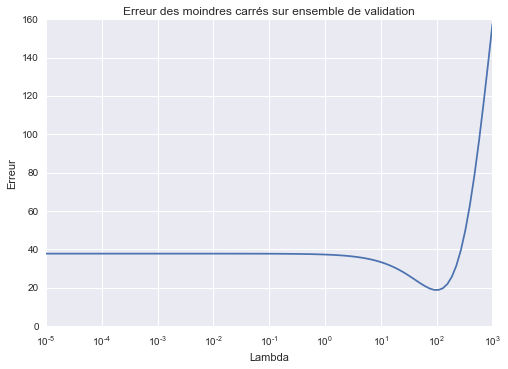

In [27]:
mse_real_ridge = []
w_ridge = []
mse_ridge_train = []
for lmd in lmds:
    w = ridge_regress(x_train, y_train, lmd)
    w_ridge.append(w[1:])
    mse_real_ridge.append(mse(y_valid, predict(w, x_valid)))
    mse_ridge_train.append(mse(y_train, predict(w, x_train)))
    
# Visualisation des données 
plt.plot(lmds, mse_real_ridge)
plt.xscale('log')
plt.title('Erreur des moindres carrés sur ensemble de validation')
plt.xlabel("Lambda")
plt.ylabel("Erreur")

On s'aperçoit qu'en pratique, sur l'ensemble de validation, la régularisation est efficace pour $\lambda \approx 10^2$. En régularisant l'estimateur, on pénalise l'overfitting (qui arrive avec la régresssion linéaire classique), ce qui permet d'obtenir de meilleurs résultats

# Lasso

In [28]:
w_lasso = []
mse_real_lasso = []
mse_lasso_train = []
for lmd in lmds:
    clf = Lasso(alpha=lmd)
    clf.fit(x_train, y_train)
    w_lasso.append(clf.coef_)
    mse_real_lasso.append(mse(y_valid, clf.predict(x_valid)))
    mse_lasso_train.append(mse(y_train, clf.predict(x_train)))

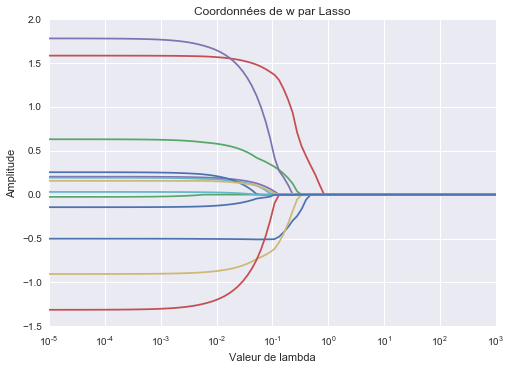

In [29]:
plt.plot(lmds, w_lasso)
plt.xscale('log')
plt.title('Coordonnées de w par Lasso')
plt.ylabel('Amplitude')
plt.xlabel('Valeur de lambda')

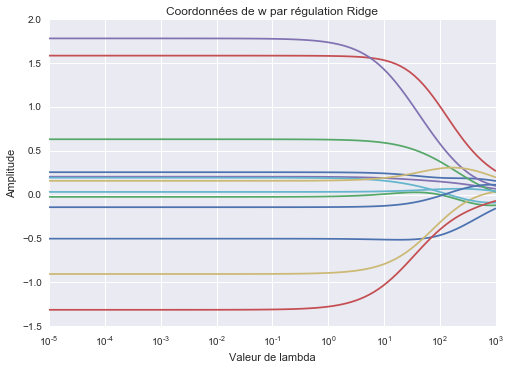

In [30]:
plt.plot(lmds, w_ridge)
plt.xscale('log')
plt.title('Coordonnées de w par régulation Ridge')
plt.ylabel('Amplitude')
plt.xlabel('Valeur de lambda')

La régularisation ridge reste valable pour des valeurs $\lambda$ supérieures à celles de la méthode par Lasso.

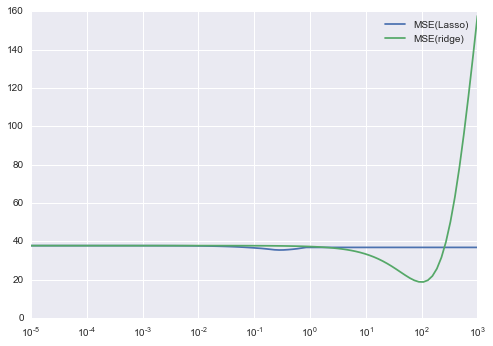

In [31]:
plt.plot(lmds, mse_real_lasso, label='MSE(Lasso)')
plt.plot(lmds, mse_real_ridge, label='MSE(ridge)')
plt.xscale('log')
plt.legend()

In [32]:
def hybrid_reg(X0, y0, lmd):
    # Lasso regression
    clf = Lasso(alpha=lmd)
    clf.fit(X0, y0)
    wlasso = clf.coef_
    
    # Selection des features pertinentes
    indexes = [i for i in range(len(wlasso)) if wlasso[i] != 0]

    # Realisation d'une régression linéaire classique
    X_bis= X0[:,indexes]
    w_hyb = regress(X_bis, y0)
    return w_hyb, indexes

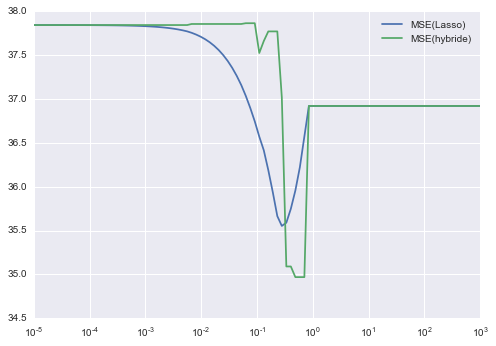

In [33]:
mse_real_hybrid = []
for lmd in lmds:
    w_hyb, indexes = hybrid_reg(x_train, y_train, lmd)
    mse_real_hybrid.append(mse(y_valid, predict(w_hyb, x_valid[:, indexes])))
    
# Tracé des erreurs en fonction de lambda
plt.plot(lmds, mse_real_lasso, label='MSE(Lasso)')
plt.plot(lmds, mse_real_hybrid, label='MSE(hybride)')
plt.xscale('log')
plt.legend()

# Bonus

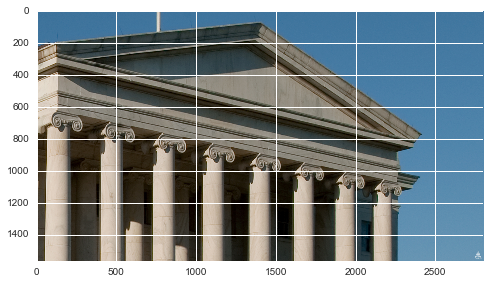

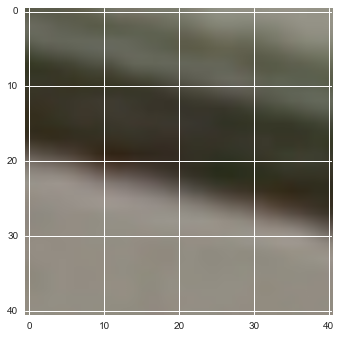

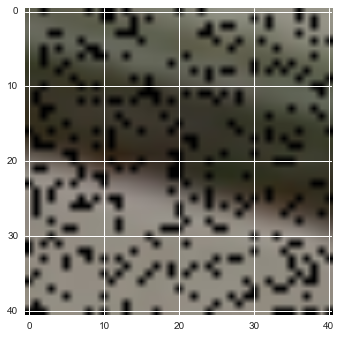

In [48]:
# Code fourni dans le TP, ne pas modifier
### Dimension du patch x-h:x+h,y-h:y+h
H = 20
### Valeur fictive pour les pixels absents
DEAD = -100
### Fichier image
IMG_FILE = "columns.jpg"

def build_dic(im,step=H):
    """ construction du dictionnaire : tous les patchs sans pixels morts en parcourant step by step l'image """
    res=[]
    step = step
    for i in range(0,im.shape[0],step):
        for j in range(0,im.shape[1],step):
            if inside(i,j,im) and np.sum(get_patch(i,j,im)[:,:,0]<=DEAD)==0:
                res.append(patch2X(get_patch(i,j,im)))
    return np.array(res).T

def patch2X(patch):
    """ transformation d'un patch en vecteur """
    return patch.reshape(-1)

def X2patch(X,h=H):
    """ transformation d'un vecteur en patch image"""
    return X.reshape(2*h+1,2*h+1,3)


def inside(i,j,im,h=H):
    """ test si un patch est valide dans l'image """
    return i-h >=0 and j-h >=0 and i+h+1<=im.shape[0] and j+h+1<=im.shape[1]

def get_patch(i,j,im,h=H):
    """ retourne un patch centre en i,j """
    return im[(i-h):(i+h+1),(j-h):(j+h+1)]

def remove_patch(i,j,im,h=H):
    """ Supprime le patch de l'image """
    imn= im.copy()
    imn[(i-h):(i+h+1),(j-h):(j+h+1)]=DEAD
    return imn,get_patch(i,j,im)

def noise_patch(patch,prc=0.2):
    """ Supprime des pixels aleatoirement """
    npatch = patch.copy().reshape(-1,3)
    height,width = patch.shape[:2]
    nb =int(prc*height*width)
    npatch[np.random.randint(0,height*width,nb),:]=DEAD
    return npatch.reshape(height,width,3)

def show(im,fig= None):
    """ affiche une image ou un patch """
    im = im.copy()
    if len(im.shape)==1 or im.shape[1]==1:
        im = X2patch(im)
    im[im<=DEAD]=-0.5
    if fig is None:
        plt.figure()
        fig = plt.imshow(hsv_to_rgb(im+0.5))
    fig.set_data(hsv_to_rgb(im+0.5))
    plt.draw()
    plt.pause(0.001)
    return fig

def read_img(img):
    """ lit un fichier image """
    im = plt.imread(img)
    if im.max()>200:
        im = im/255.
    return rgb_to_hsv(im)-0.5

if __name__ == "__main__":
    plt.ion()
    img = read_img(IMG_FILE)
    # patch = get_patch(100,100,img)
    patch = get_patch(500,1000,img)
    noisy = noise_patch(patch)
    show(img)
    show(patch)
    show(noisy)
    imgnew, oldpatch = remove_patch(100,100,img)

Questions à se poser:

Dans quel espace vit $w$?


In [49]:
def denoise(noisy_patch, dic, lmd):
    sig = patch2X(noisy_patch).copy()
    fault_indices = np.where(sig == DEAD)
    
    # Fitting training datasets
    y = np.delete(sig, fault_indices)
    X = np.delete(dic, fault_indices, axis=0)
    clf = Lasso(alpha=lmd)
    clf.fit(X, y)
    
    # Predicting value of dead pixels in patch
    X_dead = dic[fault_indices]
    sig[fault_indices] = clf.predict(X_dead)
    return sig

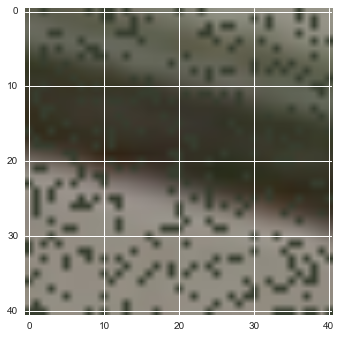

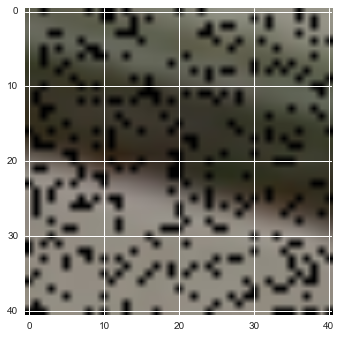

In [52]:
dic = build_dic(img)
denoisy = denoise(noisy, dic, 1)
show(denoisy)
show(noisy)

lambda =  0.0001
lambda =  0.001
lambda =  0.01
lambda =  0.1


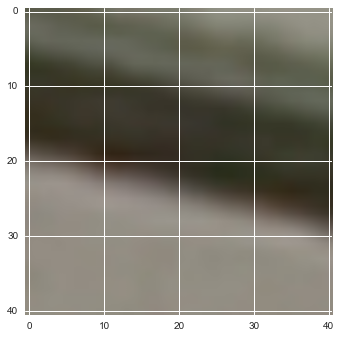

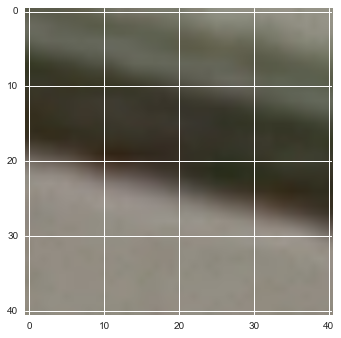

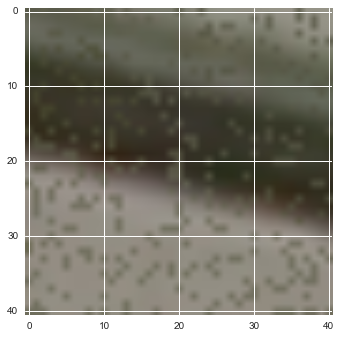

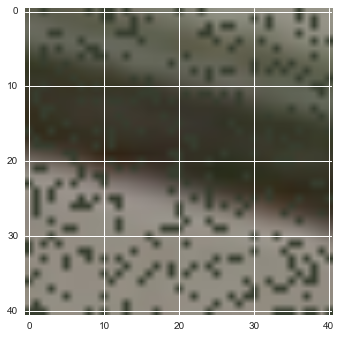

In [60]:
lmds = [0.001, 0.01, 0.1]
for lmd in lmds:
    print('lambda = ', lmd)
    show(denoise(noisy, dic, lmd))

On considère maintenant que ce n'est plus un patch, mais une partie complète de l'image qui n'est pas disponible.

Il est clair que l'ordre de remplissage est crucial dans un tel exercice, car au fur et à mesure des itérations, on s'appuiera sur la valeur prédite des pixels plus aux bords pour remplir les patchs intérieurs. Ce phénomène est très bien illustré par la référence [1] (Bin Shen and Wei Hu and Zhang, Yimin and Zhang, Yu-Jin, Image Inpainting via Sparse Representation). Dans l'illustration suivante (tirée ce cet ouvrage), on voit qu'on peut aboutir à des résultats totalement différents en fonction de l'ordre employé. 

![Importance de l'heuristique choisie pour résoudre le problème](ill1.png)